**[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)** is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The dataset serves as a direct drop-in replacement for the original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In this work, I will use the pre-trained model **VGG19**, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. The model is trained for 10 epochs with batch size of 256, compiled with `categorical_crossentropy` loss function and `Adam` optimizer.

## Data Processing
Let's first load the training and test data from csv files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Load training and test data into dataframes
data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

# X forms the training images, and y forms the training labels
X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

# X_test forms the test images, and y_test forms the test labels
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The images of fashionMNIST are black and white, while the required input for VGG19 must be colored images. Thus, I convert the images into colored ones with 3 channels R, G, B.

In [2]:
# Convert the training and test images into 3 channels
X = np.dstack([X] * 3)
X_test = np.dstack([X_test]*3)

# Display their new shapes
X.shape, X_test.shape

((60000, 784, 3), (10000, 784, 3))

Let's reshape the images into tensor format as required by TensorFlow.

In [3]:
# Reshape images as per the tensor format required by tensorflow
X = X.reshape(-1, 28,28,3)
X_test= X_test.reshape (-1,28,28,3)

# Display the new shape
X.shape, X_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

VGG19 requires minimum input image's width and height of 48, but I'll resize my images from 28 x 28 to 150 x 150.

In [4]:
# Resize the images as 150 * 150 as required by VGG19
from keras.preprocessing.image import img_to_array, array_to_img

X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X_test])

# Display the new shape
X.shape, X_test.shape

((60000, 150, 150, 3), (10000, 150, 150, 3))

Here, I preprocess the images by reshaping them into the shape the network expects and scaling them so that all values are in the [0, 1] interval. For instance, the training images were stored in an array of shape (60000, 150, 150, 3) of type uint8 with values in the [0, 255] interval. I transform them into a float32 array of shape (60000, 150, 150, 3) with values between 0 and 1.

In [5]:
# Normalise the data and change data type
X = X.astype('float32')
X /= 255

X_test = X_test.astype('float32')
X_test /= 255

Here, I split the original training data (60,000 images) into 80% training (48,000 images) and 20% validation (12000 images) optimize the classifier, while keeping the test data (10,000 images) to finally evaluate the accuracy of the model on the data it has never seen. This helps to see whether I'm over-fitting on the training data and whether I should lower the learning rate and train for more epochs if validation accuracy is higher than training accuracy or stop over-training if training accuracy shift higher than the validation.

In [6]:
from sklearn.model_selection import train_test_split

# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((48000, 150, 150, 3), (12000, 150, 150, 3), (48000, 10), (12000, 10))

## VGG19
A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A **pretrained network** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer-vision problems, even though these new problems may involve completely different classes than those of the original task.

I'll use the [VGG19 architecture](https://arxiv.org/abs/1409.1556), developed by Karen Simonyan and Andrew Zisserman in 2014. It’s a simple and widely used convnet architecture for ImageNet. The model comes pre-packaged with Keras. Let's instantiate it:

In [7]:
from keras.applications import VGG19

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (150, 150, 3), classes = 10)

I passed 4 arguments to the constructor:
* `weights` specifies the weight checkpoint from which to initialize the model.
* `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because I intend to use my own densely connected classifier (with only 10 classes), I don’t need to include it.
* `input_shape`: optional shape tuple, only to be specified if `include_top` is False.
* `classes`: optional number of classes to classify images into, only to be specified if `include_top` is True, and if no `weights` argument is specified.

Here's the detail of the architecture of the VGG19 convolutional base.

In [8]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Feature Extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

CNNs used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the **"convolutional base"** of the model. In the case of convnets, **"feature extraction"** will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![feature-extraction](images/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Looking back at the VGG 19 architecture, the final feature map has shape `(4, 4, 512)`. That's the feature on top of which I will stick a densely-connected classifier. First, let's pre-process the data so that it's trainable using VGG19.

In [9]:
from keras.applications.vgg19 import preprocess_input

# Preprocessing the input 
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

Now, in order to extract features from Fashion-MNIST, I will:
* Run the convolutional base over the dataset.
* Record its output to a Numpy array on disk. 
* Use this data as input to a standalone densely-connected classifier.

This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow me to leverage data augmentation at all.

Now I will extract features from the train, test, and validation data simply by calling the `predict` method of the `vgg19` model.

In [10]:
# Extracting features
train_features = vgg19.predict(np.array(X_train), batch_size=256, verbose=1)
test_features = vgg19.predict(np.array(X_test), batch_size=256, verbose=1)
val_features = vgg19.predict(np.array(X_val), batch_size=256, verbose=1)

12000/12000 [==============================] - 72s 6ms/step


In [11]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, y_val)

In [12]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

((48000, 4, 4, 512), '\n', (10000, 4, 4, 512), '\n', (12000, 4, 4, 512))


The extracted features are currently of shape `(samples, 4, 4, 512)`. I will feed them to a densely-connected classifier, so first I must flatten them to `(samples, 8192)`:

In [13]:
# Flatten extracted features
train_features = np.reshape(train_features, (48000, 4*4*512))
test_features = np.reshape(test_features, (10000, 4*4*512))
val_features = np.reshape(val_features, (12000, 4*4*512))

At this point, I can define the densely-connected classifier (note the use of dropout for regularization), and train it on the data and labels that I just recorded:

In [14]:
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

When compiling the model, I choose **categorical_crossentropy** as the loss function (which is relevent for multiclass, single-label classification problem) and **Adam** optimizer.
* The cross-entropy loss calculates the error rate between the predicted value and the original value. The formula for calculating cross-entropy loss is given [here](https://en.wikipedia.org/wiki/Cross_entropy). Categorical is used because there are 10 classes to predict from. If there were 2 classes, I would have used binary_crossentropy.
* The Adam optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is responsible for updating the weights of the neurons via backpropagation. It calculates the derivative of the loss function with respect to each weight and subtracts it from the weight. That is how a neural network learns.

In [15]:
import keras

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

## Training the Model
As previously mentioned, I train the model with batch size of 256 and 10 epochs on both training and validation data.

In [16]:
# Train the the model
history = model.fit(train_features, y_train,
          batch_size=256,
          epochs=50,
          verbose=1,
          validation_data=(val_features, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 3s 67us/step - loss: 1.9221 - acc: 0.3443 - val_loss: 1.3791 - val_acc: 0.6001
Epoch 2/50
48000/48000 [==============================] - 3s 56us/step - loss: 1.2921 - acc: 0.5343 - val_loss: 1.0462 - val_acc: 0.6325
Epoch 3/50
48000/48000 [==============================] - 3s 55us/step - loss: 1.1065 - acc: 0.6021 - val_loss: 0.9350 - val_acc: 0.6776
Epoch 4/50
48000/48000 [==============================] - 3s 56us/step - loss: 1.0226 - acc: 0.6267 - val_loss: 0.9029 - val_acc: 0.6947
Epoch 5/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9720 - acc: 0.6465 - val_loss: 0.8144 - val_acc: 0.6997
Epoch 6/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9393 - acc: 0.6546 - val_loss: 0.7923 - val_acc: 0.7165
Epoch 7/50
48000/48000 [==============================] - 3s 55us/step - loss: 0.9196 - acc: 0.6638 - val_loss: 0.7616 - val_acc

In [17]:
score = model.evaluate(test_features, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.6238402219772339)
('Test accuracy:', 0.7664)


Hmm, the test accuracy using pre-trained model si only 76.64%.

## Results
Let's plot training and validation accuracy as well as training and validation loss.

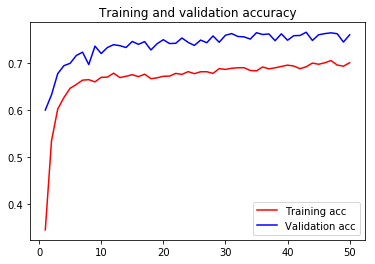

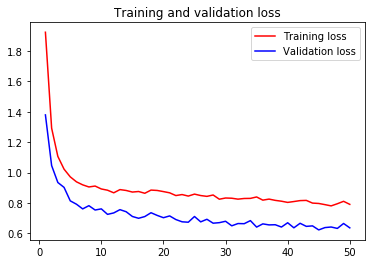

In [18]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

Although the lines of loss and accuracy for both training and validation follow similar trends, there're some space between their values.

## Classification Report
I can summarize the performance of my classifier as follows:

In [19]:
# get the predictions for the test data
predicted_classes = model.predict_classes(test_features)

# get the indices to be plotted
y_true = data_test.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [20]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.63      0.83      0.71      1000
    Class 1       0.94      0.95      0.95      1000
    Class 2       0.68      0.56      0.61      1000
    Class 3       0.81      0.79      0.80      1000
    Class 4       0.62      0.76      0.68      1000
    Class 5       0.77      0.95      0.85      1000
    Class 6       0.50      0.27      0.35      1000
    Class 7       0.89      0.77      0.82      1000
    Class 8       0.87      0.94      0.90      1000
    Class 9       0.91      0.85      0.88      1000

avg / total       0.76      0.77      0.76     10000



The model underperforms for Class 2 and 6. It lacks precision for class 0 and 4, additionally. 

In [21]:
test_features[correct].shape

(7664, 8192)